# Clustering based on eRegulons

In [ ]:
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt
%matplotlib inline
# Set out directory
outDir = '/Users/jinhuixin/Master/thesis/GRN/BS1140/eRegulon_cluster/'

In [ ]:
# load scenic+ object
import dill
infile = open('/Users/jinhuixin/Master/thesis/GRN/BS1140/scenicplus/scplus_obj_4Pando.pkl', 'rb')
scplus_obj = dill.load(infile)
infile.close()

eRegulon_AUC: dataframe with eRegulon enrichment scores calculated using AUCell

filtered means only keep eRegulons for which the region-to-gene correlation is positive (+_+ and -_+)

In [ ]:
# Create annadata from AUC matrix (use both gene and region-based cistromes)
import pandas as pd
import anndata
auc_key = 'eRegulon_AUC_filtered'
signature_keys = ['Gene_based', 'Region_based']
data_mat = pd.concat([scplus_obj.uns[auc_key][x].T for x in signature_keys])
#selected_regulons = [x for x in data_mat.index if '+_' in x or '-_' in x]
#data_mat = data_mat.loc[selected_regulons]
adata = anndata.AnnData(X=data_mat.T.copy())
adata.obs = scplus_obj.metadata_cell.copy()

/var/folders/73/t_19bmpd5m7bnvd_88sxp6lw0000gn/T/ipykernel_1714/980402785.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(X=data_mat.T.copy())


In [ ]:
adata.var_names # variables are eRegulons

Index(['NFATC3_+_(14g)', 'BATF_-_(31g)', 'REL_-_(26g)', 'TRPS1_-_(14g)',
       'KLF2_+_(93g)', 'SP140_extended_-_(19g)', 'PHF20_+_(60g)',
       'REL_+_(16g)', 'ZNF441_+_(11g)', 'NR2F2_+_(12g)',
       ...
       'NRF1_-_(25r)', 'RARG_+_(16r)', 'SREBF2_+_(22r)', 'RELB_+_(36r)',
       'RORA_+_(53r)', 'CREB1_+_(46r)', 'MBD2_+_(27r)', 'CEBPD_+_(54r)',
       'JUND_-_(161r)', 'BNC2_+_(53r)'],
      dtype='object', length=468)

umap calculation is copied from scenic+ function run_eRegulons_umap()

In [ ]:
data_mat = data_mat.T.fillna(0)

In [ ]:
import umap
embedding = umap.UMAP(random_state=555).fit_transform(X = data_mat)
data_names = data_mat.columns.tolist()
dr = np.array(embedding)
adata.obsm['X_umap'] = dr # rewrite the umap

In [ ]:
import scanpy as sc
sc.pp.neighbors(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [ ]:
# cluster on umap
sc.tl.leiden(adata, resolution=1)

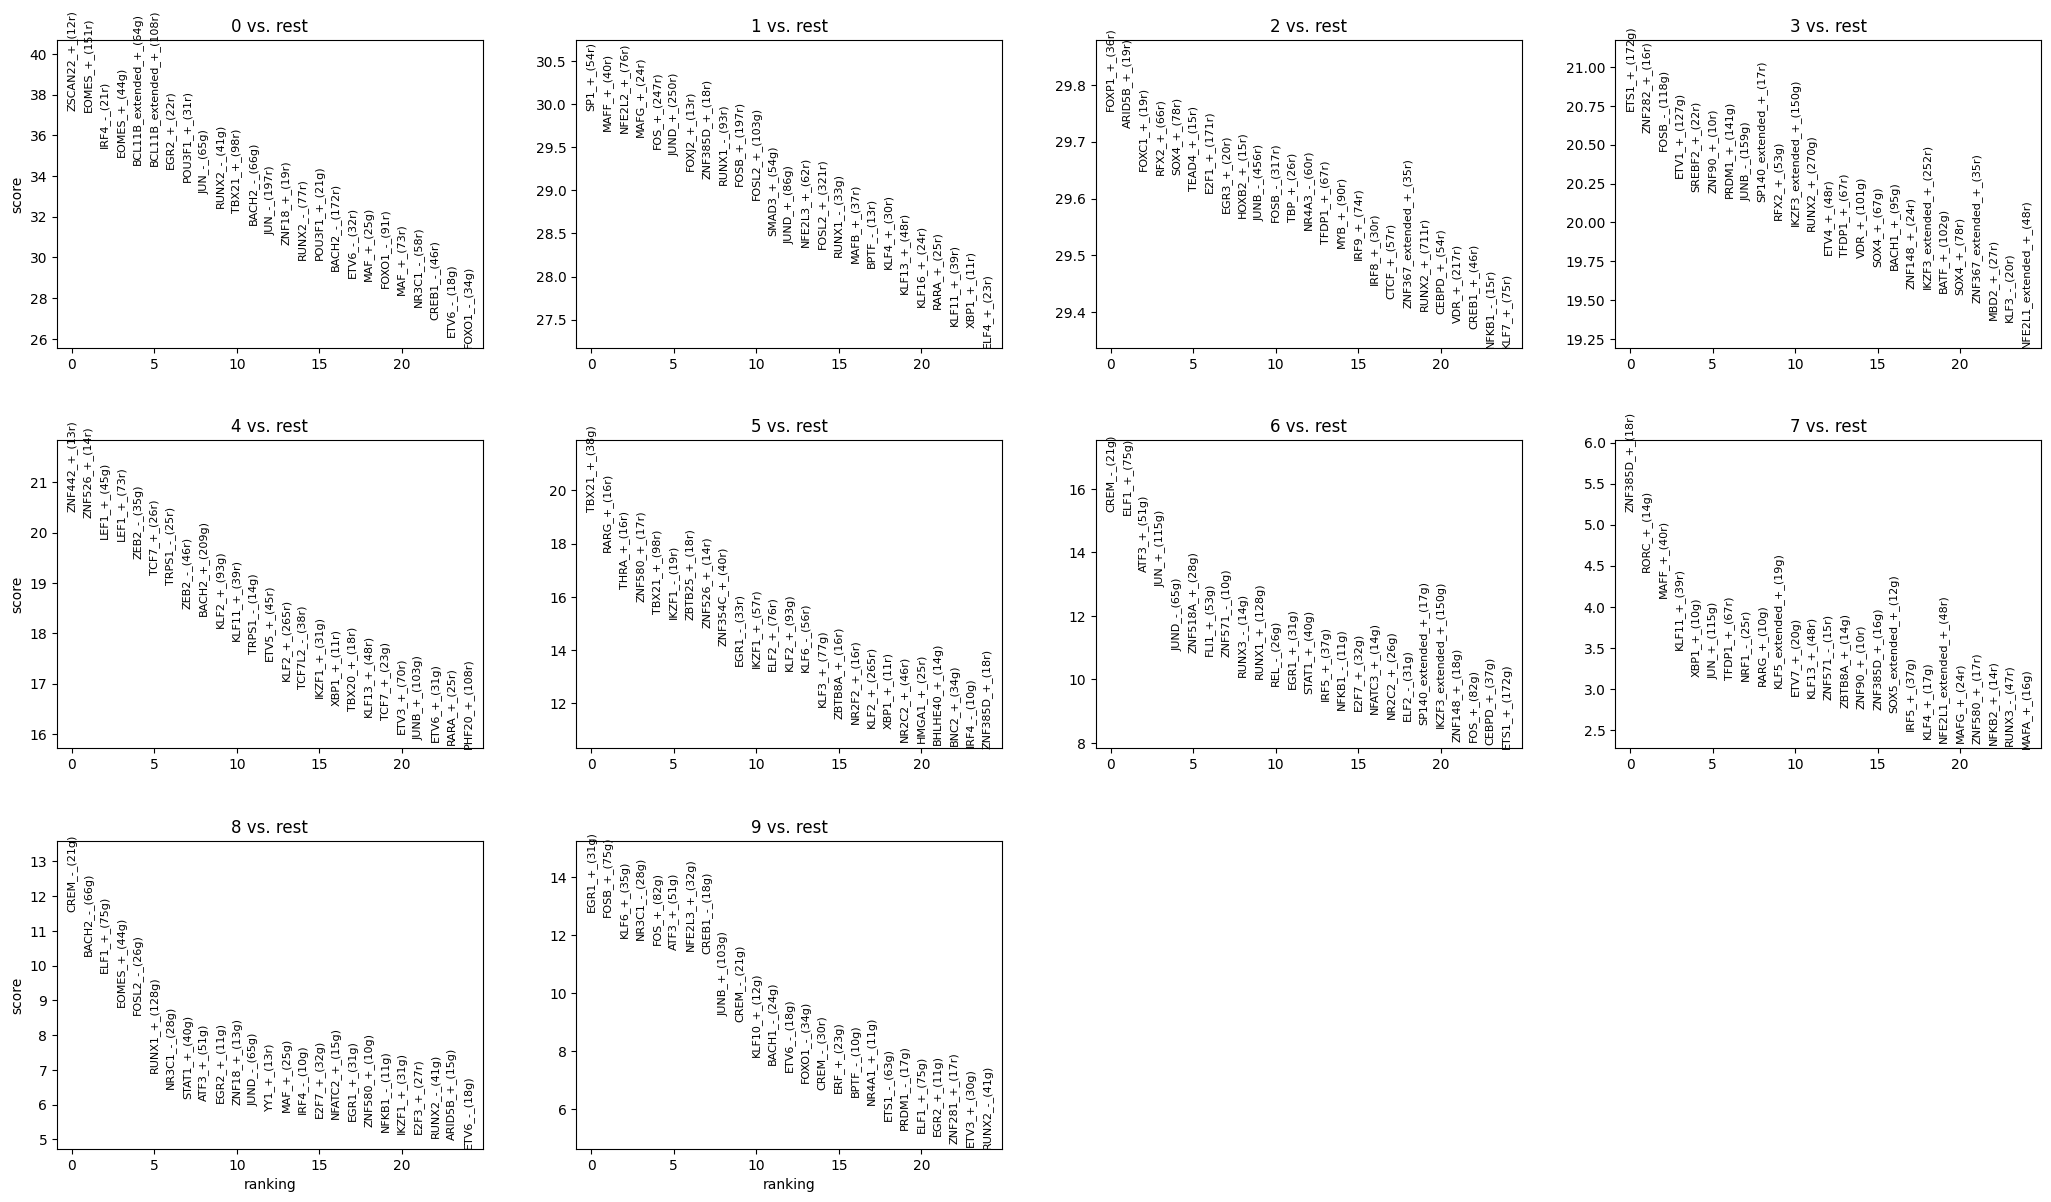

In [ ]:
# top differential variables
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
# save eRegulon cluster
adata.write_h5ad(outDir+'eR_cluster_anndata.h5ad')

# Cross check cluster vs. scRNA & scATAC 

In [ ]:
import scanpy as sc
adata = sc.read_h5ad(outDir+'eR_cluster_anndata.h5ad')

Louvain Group |Markers/Name 
-----|-----
0| ZSCAN22+EOMES+
1| SP1+MAFF+
2| FOXP1+ARID5B+
3| ETS1+ZNF282+
4| ZNF442+ZNF526+
5| TBX21+RARG+
6| CREM-ELF1+
7| ZNF385D+RORC+
8| CREM-BACH2-
9| EGR1+FOSB+

In [ ]:
new_cluster_names = ['0-ZSCAN22+EOMES+',
                     '1-SP1+MAFF+',
                     '2-FOXP1+ARID5B+',
                     '3-ETS1+ZNF282+',
                     '4-ZNF442+ZNF526+',
                     '5-TBX21+RARG+',
                     '6-CREM-ELF1+',
                     '7-ZNF385D+RORC+',
                     '8-CREM-BACH2-',
                     '9-EGR1+FOSB+']
adata.rename_categories('leiden', new_cluster_names)

/Users/jinhuixin/miniconda3/envs/scenicplus/lib/python3.9/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


In [ ]:
scplus_obj.metadata_cell['eRegulon_cluster'] = adata.obs['leiden'] # add eR cluster names to scenic+ object
# export eR cluster info
tmp_df = scplus_obj.metadata_cell['eRegulon_cluster']
tmp_df.to_csv('BS1140/cluster_overlap/eRegulon_celltype.csv')

In [ ]:
# import rna cell type
import pandas as pd
rna_sct_celltype = pd.read_csv('../GRN/BS1140/intigrate_RNA_scenic+/bs1140_celltype_rna_sct_assay.csv', index_col=0)
rna_sct_celltype.index = rna_sct_celltype.index.values + '-BS1140'
rna_sct_celltype.head()

,celltype_rna_sct_assay
ATTAGTCCACCCACCT-1-BS1140,M-GZMK+
CGTCAATAGCCTGATG-1-BS1140,Naive-SESN3+
TATGTGATCATTGTTC-1-BS1140,Ex-ENTPD1+
ATTACCCGTTGTAAAC-1-BS1140,IKZF2+PITPNC1+
GCCTGTGCAGGAAGCC-1-BS1140,Naive-SESN3+


In [ ]:
adata.obs['rna_sct_celltype'] = rna_sct_celltype # add to metadata

In [ ]:
# check 3 cluster annotation
print(adata.obs['rna_sct_celltype'].unique()) #scRNA
print(adata.obs['GEX_cluster_archr'].unique()) #scATAC
print(adata.obs['leiden'].unique()) #eR

['M-IL7R+' 'Ex-ENTPD1+' 'M-CD69+' 'Prol-STMN1+TOP2A+' 'M-GZMK+'
 'GNLY+NKG7+' 'Naive-SESN3+' 'GNLY+IKZF2+' 'CMSS1+FILIP1L+'
 'IKZF2+PITPNC1+']
['C8-Memory-1', 'C2-Exhausted-2', 'C6-EM-2', 'C1-Exhausted-1', 'C5-EM-1', 'C9-Memory-2', 'C4-EMRA', 'C3-Naive', 'C7']
Categories (9, object): ['C1-Exhausted-1', 'C2-Exhausted-2', 'C3-Naive', 'C4-EMRA', ..., 'C6-EM-2', 'C7', 'C8-Memory-1', 'C9-Memory-2']
['1-SP1+MAFF+', '3-ETS1+ZNF282+', '8-CREM-BACH2-', '2-FOXP1+ARID5B+', '0-ZSCAN22+EOMES+', '9-EGR1+FOSB+', '4-ZNF442+ZNF526+', '5-TBX21+RARG+', '6-CREM-ELF1+', '7-ZNF385D+RORC+']
Categories (10, object): ['0-ZSCAN22+EOMES+', '1-SP1+MAFF+', '2-FOXP1+ARID5B+', '3-ETS1+ZNF282+', ..., '6-CREM-ELF1+', '7-ZNF385D+RORC+', '8-CREM-BACH2-', '9-EGR1+FOSB+']


In [ ]:
adata.obs['eRegulon_celltype'] = adata.obs['leiden'] # copy to a new column
RNA_eR_cluster = adata.obs[['rna_sct_celltype','eRegulon_celltype']] # df RNA vs eR
ATAC_eR_cluster =adata.obs[['GEX_cluster_archr','eRegulon_celltype']] # df ATAC vs eR
RNA_ATAC_cluster = adata.obs[['rna_sct_celltype','GEX_cluster_archr']] # df RNA vs ATAC

## Sankey plot

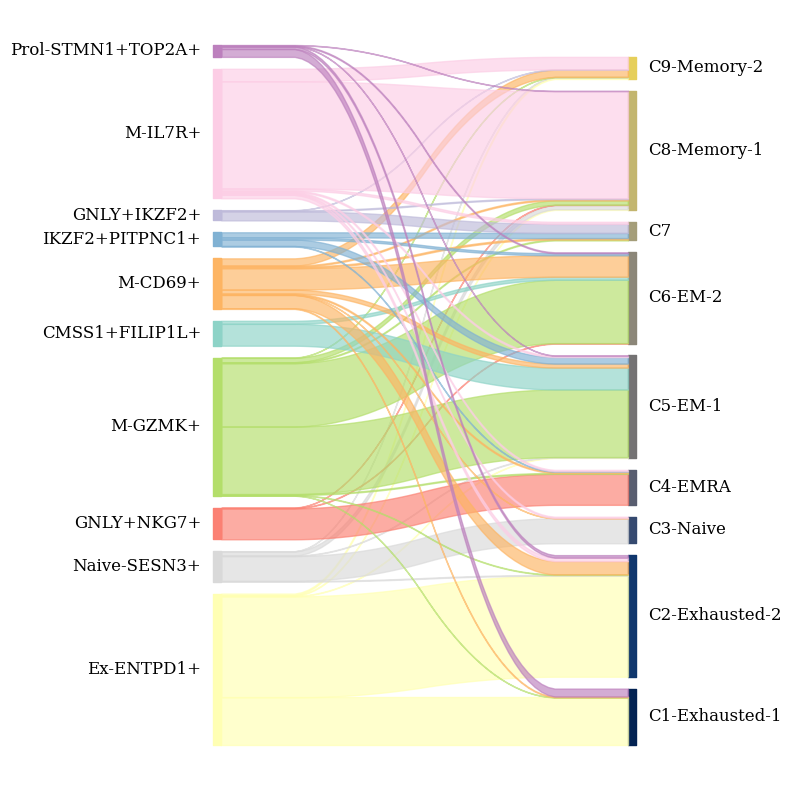

In [ ]:
# RNA vs ATAC
from pysankey import sankey
import matplotlib.pyplot as plt
colorDict = {
    'CMSS1+FILIP1L+':"#8DD3C7",
    'Ex-ENTPD1+':"#FFFFB3",
    'GNLY+IKZF2+':"#BEBADA",
    'GNLY+NKG7+':"#FB8072",
    'IKZF2+PITPNC1+':"#80B1D3",
    'M-CD69+':"#FDB462",
    'M-GZMK+':"#B3DE69",
    'M-IL7R+':"#FCCDE5",
    'Naive-SESN3+':"#D9D9D9",
    'Prol-STMN1+TOP2A+':"#BC80BD",
    'C1-Exhausted-1':"#002051",
    'C2-Exhausted-2':"#0d346b",
    'C3-Naive':"#33486e",
    'C4-EMRA':"#575c6e",
    'C5-EM-1':"#737172",
    'C6-EM-2':"#8b8677",
    'C7':"#a49d78",
    'C8-Memory-1':"#c3b56d",
    'C9-Memory-2':"#e6cf59",
}
sankey(right = RNA_ATAC_cluster["GEX_cluster_archr"], left = RNA_ATAC_cluster['rna_sct_celltype'], 
       colorDict = colorDict,
       rightLabels=['C1-Exhausted-1',
                    'C2-Exhausted-2',
                    'C3-Naive',
                    'C4-EMRA',
                    'C5-EM-1',
                    'C6-EM-2',
                    'C7',
                    'C8-Memory-1',
                    'C9-Memory-2'],
        leftLabels = ['Ex-ENTPD1+','Naive-SESN3+','GNLY+NKG7+','M-GZMK+','CMSS1+FILIP1L+','M-CD69+','IKZF2+PITPNC1+','GNLY+IKZF2+','M-IL7R+','Prol-STMN1+TOP2A+'],
        fontsize = 12
)
fig = plt.gcf()
fig.set_size_inches(6,10)
fig.set_facecolor("w")
fig.savefig("./BS1140/cluster_overlap/rna_atac_sankey_plot.pdf", dpi = 300, bbox_inches = "tight")

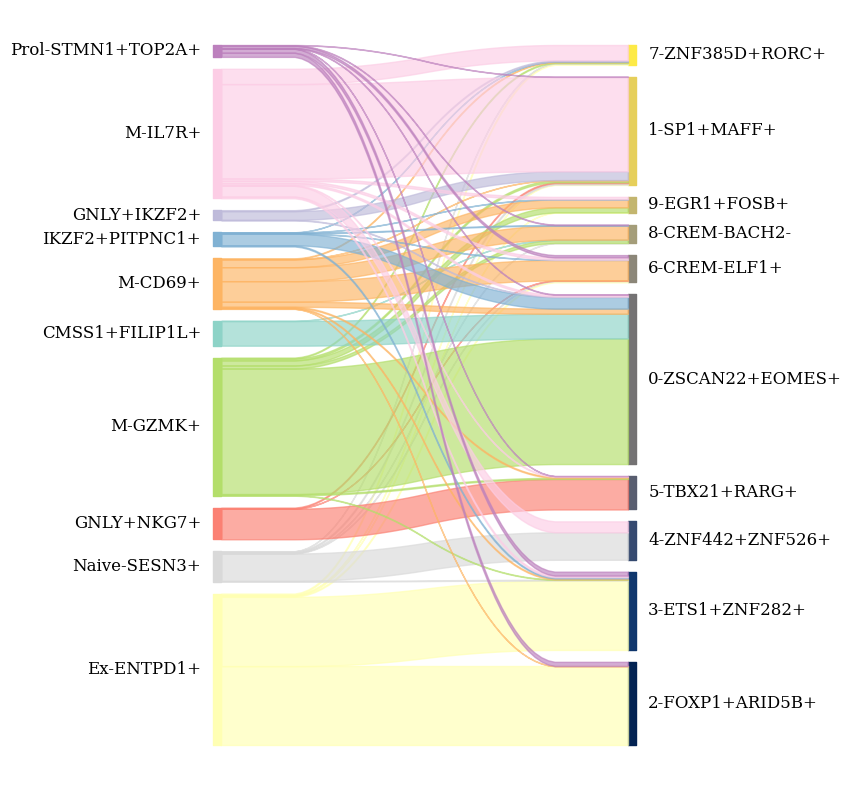

In [ ]:
# RNA vs eR
colorDict = {
    'CMSS1+FILIP1L+':"#8DD3C7",
    'Ex-ENTPD1+':"#FFFFB3",
    'GNLY+IKZF2+':"#BEBADA",
    'GNLY+NKG7+':"#FB8072",
    'IKZF2+PITPNC1+':"#80B1D3",
    'M-CD69+':"#FDB462",
    'M-GZMK+':"#B3DE69",
    'M-IL7R+':"#FCCDE5",
    'Naive-SESN3+':"#D9D9D9",
    'Prol-STMN1+TOP2A+':"#BC80BD",
    '2-FOXP1+ARID5B+':"#002051",
    '3-ETS1+ZNF282+':"#0d346b",
    '4-ZNF442+ZNF526+':"#33486e",
    '5-TBX21+RARG+':"#575c6e",
    '0-ZSCAN22+EOMES+':"#737172",
    '6-CREM-ELF1+':"#8b8677",
    '8-CREM-BACH2-':"#a49d78",
    '9-EGR1+FOSB+':"#c3b56d",
    '1-SP1+MAFF+':"#e6cf59",
    '7-ZNF385D+RORC+':"#fdea45"
}
sankey(right = RNA_eR_cluster["eRegulon_celltype"], left = RNA_eR_cluster['rna_sct_celltype'], 
       colorDict = colorDict,
       rightLabels=['2-FOXP1+ARID5B+',
                    '3-ETS1+ZNF282+',
                    '4-ZNF442+ZNF526+',
                    '5-TBX21+RARG+',
                    '0-ZSCAN22+EOMES+',
                    '6-CREM-ELF1+',
                    '8-CREM-BACH2-',
                    '9-EGR1+FOSB+',
                    '1-SP1+MAFF+',
                    '7-ZNF385D+RORC+'],
        leftLabels = ['Ex-ENTPD1+','Naive-SESN3+','GNLY+NKG7+','M-GZMK+','CMSS1+FILIP1L+','M-CD69+','IKZF2+PITPNC1+','GNLY+IKZF2+','M-IL7R+','Prol-STMN1+TOP2A+'],
        fontsize = 12
)
fig = plt.gcf()
fig.set_size_inches(6,10)
fig.set_facecolor("w")
fig.savefig("./BS1140/cluster_overlap/rna_eR_sankey_plot.pdf", dpi = 300, bbox_inches = "tight")


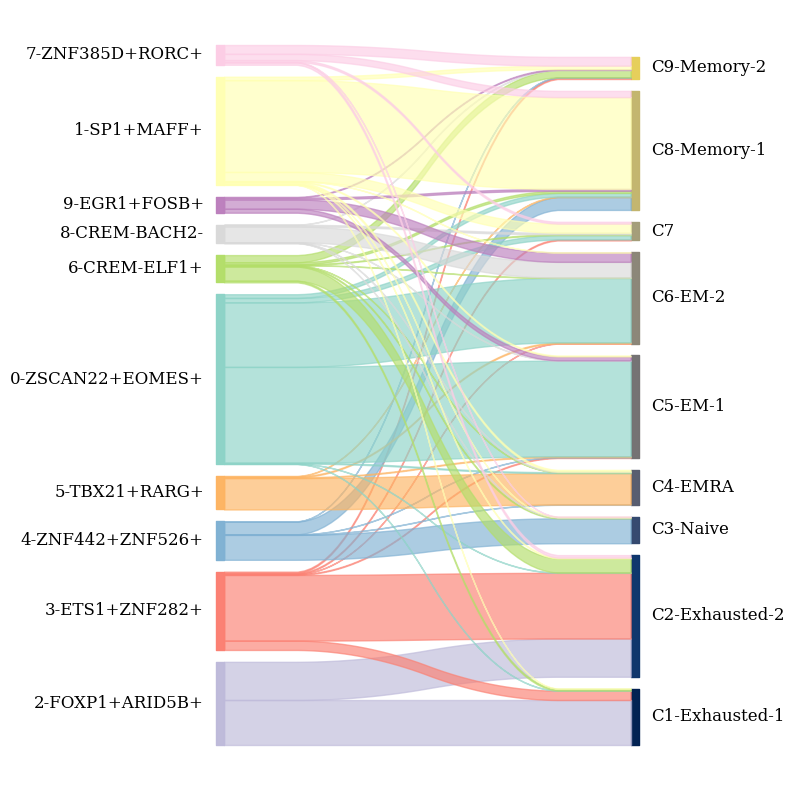

In [ ]:
# ATAC vs eR
from pysankey import sankey
import matplotlib.pyplot as plt
colorDict = {
    '2-FOXP1+ARID5B+':"#BEBADA",
    '3-ETS1+ZNF282+':"#FB8072",
    '4-ZNF442+ZNF526+':"#80B1D3",
    '5-TBX21+RARG+':"#FDB462",
    '0-ZSCAN22+EOMES+':"#8DD3C7",
    '6-CREM-ELF1+':"#B3DE69",
    '8-CREM-BACH2-':"#D9D9D9",
    '9-EGR1+FOSB+':"#BC80BD",
    '1-SP1+MAFF+':"#FFFFB3",
    '7-ZNF385D+RORC+':"#FCCDE5",
    'C1-Exhausted-1':"#002051",
    'C2-Exhausted-2':"#0d346b",
    'C3-Naive':"#33486e",
    'C4-EMRA':"#575c6e",
    'C5-EM-1':"#737172",
    'C6-EM-2':"#8b8677",
    'C7':"#a49d78",
    'C8-Memory-1':"#c3b56d",
    'C9-Memory-2':"#e6cf59",
}
sankey(right = ATAC_eR_cluster["GEX_cluster_archr"], left = ATAC_eR_cluster['eRegulon_celltype'], 
       colorDict = colorDict,
       rightLabels=['C1-Exhausted-1',
                    'C2-Exhausted-2',
                    'C3-Naive',
                    'C4-EMRA',
                    'C5-EM-1',
                    'C6-EM-2',
                    'C7',
                    'C8-Memory-1',
                    'C9-Memory-2'],
        leftLabels = ['2-FOXP1+ARID5B+',
                    '3-ETS1+ZNF282+',
                    '4-ZNF442+ZNF526+',
                    '5-TBX21+RARG+',
                    '0-ZSCAN22+EOMES+',
                    '6-CREM-ELF1+',
                    '8-CREM-BACH2-',
                    '9-EGR1+FOSB+',
                    '1-SP1+MAFF+',
                    '7-ZNF385D+RORC+'],
        fontsize = 12
)
fig = plt.gcf()
fig.set_size_inches(6,10)
fig.set_facecolor("w")
fig.savefig("./BS1140/cluster_overlap/atac_eR_sankey_plot.pdf", dpi = 300, bbox_inches = "tight")

## Heatmap

In [ ]:
RNA_eR_ct = pd.crosstab(RNA_eR_cluster['eRegulon_celltype'],RNA_eR_cluster['rna_sct_celltype'], normalize='columns')
RNA_eR_ct_r = pd.crosstab(RNA_eR_cluster['eRegulon_celltype'],RNA_eR_cluster['rna_sct_celltype'], normalize='index')

In [ ]:
RNA_eR_ct = RNA_eR_ct.loc[:,['CMSS1+FILIP1L+','M-GZMK+','IKZF2+PITPNC1+','GNLY+IKZF2+','M-IL7R+','Ex-ENTPD1+','Prol-STMN1+TOP2A+','Naive-SESN3+','GNLY+NKG7+','M-CD69+']]
RNA_eR_ct_r = RNA_eR_ct_r.loc[:,['M-GZMK+','M-IL7R+','Ex-ENTPD1+','Naive-SESN3+','GNLY+NKG7+','M-CD69+','CMSS1+FILIP1L+','GNLY+IKZF2+','IKZF2+PITPNC1+','Prol-STMN1+TOP2A+']]

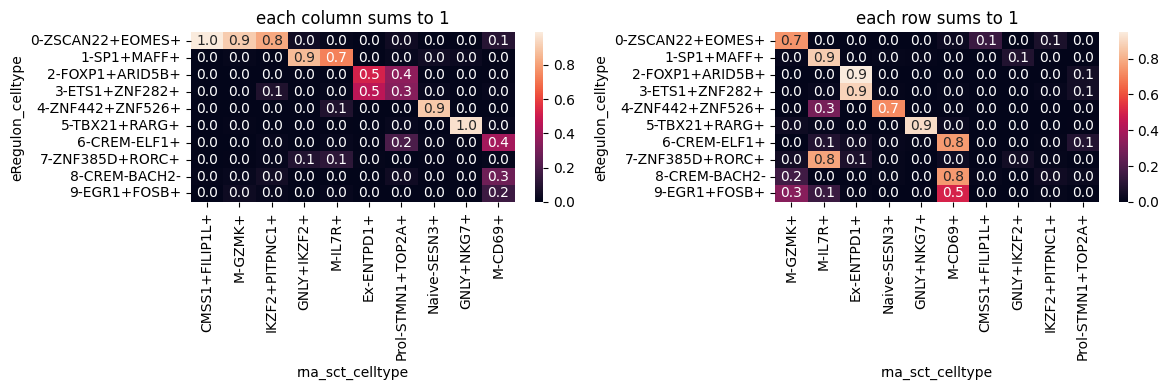

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1,2, figsize =(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(RNA_eR_ct, annot=True, fmt='.1f', ax = ax[0])
plt.subplot(1, 2, 2)
sns.heatmap(RNA_eR_ct_r, annot=True, fmt='.1f', ax = ax[1])
ax[0].set_title('each column sums to 1')
ax[1].set_title('each row sums to 1')
plt.tight_layout()

## scATAC - eRegulons cluster results

In [ ]:
ATAC_eR_ct = pd.crosstab(ATAC_eR_cluster['eRegulon_celltype'],ATAC_eR_cluster['GEX_cluster_archr'], normalize='columns')
ATAC_eR_ct_r = pd.crosstab(ATAC_eR_cluster['eRegulon_celltype'],ATAC_eR_cluster['GEX_cluster_archr'], normalize='index')

In [ ]:
ATAC_eR_ct = ATAC_eR_ct.loc[:,['C5-EM-1','C6-EM-2',"C8-Memory-1","C7","C1-Exhausted-1","C2-Exhausted-2","C3-Naive","C4-EMRA","C9-Memory-2"]]
ATAC_eR_ct_r = ATAC_eR_ct_r.loc[:,['C5-EM-1','C8-Memory-1','C1-Exhausted-1','C2-Exhausted-2','C3-Naive','C4-EMRA','C9-Memory-2','C6-EM-2','C7']]

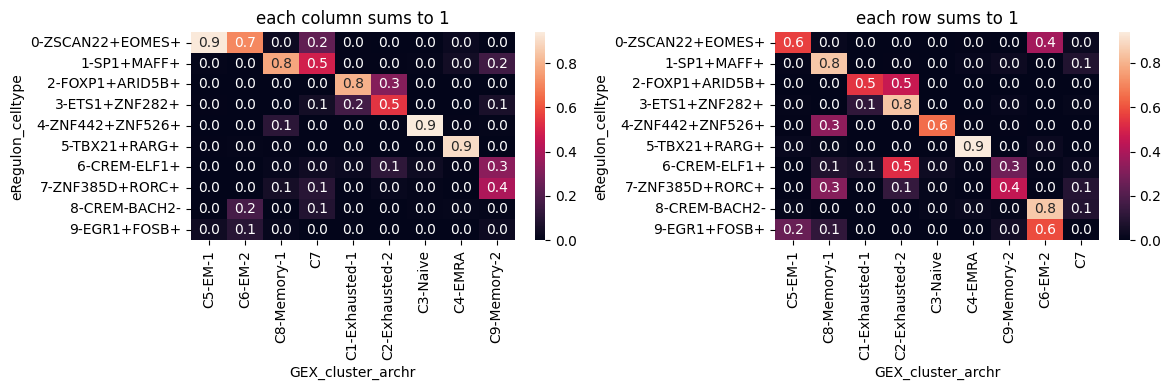

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1,2, figsize =(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(ATAC_eR_ct, annot=True, fmt='.1f', ax = ax[0])
plt.subplot(1, 2, 2)
sns.heatmap(ATAC_eR_ct_r, annot=True, fmt='.1f', ax = ax[1])
ax[0].set_title('each column sums to 1')
ax[1].set_title('each row sums to 1')
plt.tight_layout()

In [ ]:
adata.write_h5ad(outDir+'eR_cluster_anndata.h5ad')